In [1]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import regex
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from pycontractions import Contractions 

In [2]:
train_data = pd.read_csv('train.csv')

In [3]:
test_data = pd.read_csv('test.csv', dtype={'Id':str,'Tweet':str})

In [4]:
cat_mapping = {'negative':0, 'neutral':1, 'positive':2}
reverse_cat_mapping = {0:'negative', 1:'neutral', 2:'positive'}

In [5]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

In [6]:
train_data.shape

(5970, 3)

In [7]:
test_data.shape

(9968, 2)

Liczba wartości pustych NaN w zbiorach

In [8]:
train_data['Tweet'].isna().sum()

0

In [9]:
test_data['Tweet'].isna().sum()

5968

Liczba wartości pustych tweeta "Not Available"

In [10]:
train_data[train_data['Tweet'] == 'Not Available'].shape

(548, 3)

In [11]:
test_data[test_data['Tweet'] == 'Not Available'].shape

(360, 2)

Przykład pozytywnego tweeta ze smutnym emotikonem 

In [12]:
train_data.iloc[5668]

Id                                                                                                              641103045087113216
Category                                                                                                                  positive
Tweet       @ayelacey I loved it! I didnt wanna come back haha. Spending Saturday on Venice Beach and now back in this cold lol :(
Name: 5668, dtype: object

Ekspresyjne tweety, zawierające znaki "?" oraz "!"

In [13]:
train_data[train_data['Tweet'].str.contains('\?\!')]

,Id,Category,Tweet
281,641644400880148480,positive,Minutes aways for the unvieling of iphone6splus or is it going to be Iphone 7??????!?!?!?!? http://t.co/fRltFMjkCK
848,636243185342136320,positive,Jurassic World is back in @IMAX theaters for one week starting Friday! Who's going?!
1478,640357745984602112,negative,When your friend gets a Lexus for her 15th birthday and you can't even afford a taco from the taco truck!??!!
1560,641220766877511680,positive,Just one more day to go -&gt;&gt; Madonna's Rebel Heart Tour starts tomorrow. What to expect?! http://t.co/OXCAc47pTi
1815,640455441403768834,neutral,"Sunday Supplement. Is Bale in the same class as Messi and Ronaldo?! ""He's knocking on the door"" don't make me laugh. Over hyped as always"
1817,640477752961986560,positive,Nice to be in the @guardian_sport YouTube round up. Mine is the last link - Messi is the headline. Surely a mix-up?! http://t.co/KheYatUISH
1860,641469128990191616,positive,"And Argentina say Messi does nothing for the national team??! That goal was just magical Messi time as usual, c'mon! XD"
2129,627603448981258240,positive,@Anomaly100 @marpeesh @HMiglino @TeaPainUSA No wonder you think Michelle Obama may be attractive?!?
2552,641208536333189120,neutral,Seriously can things just go right in my day?! Turns out the Nike run is tomorrow
2579,641625453795651584,negative,"White girls be so annoying with accessories, why you wearing a striped sun dress with a Nike hat and coach bag???!"


Kategorie tweetów w zbiorze treningowym

In [14]:
train_data['Category'].value_counts()

positive    2888
neutral     2125
negative     956
Tweet          1
Name: Category, dtype: int64

Kategorie tweetów z wartościami pustymi

In [15]:
train_data[train_data['Tweet'] == 'Not Available']['Category'].value_counts()

positive    289
neutral     172
negative     87
Name: Category, dtype: int64

Rodzaje Tweetów, około 10% pustych wartości

In [16]:
train_data['Tweet'].value_counts(True)

Not Available                                                                                                                                   0.091792
@pperrin @nellesapelle Very wise. Hard to see UKIP going any further tho. Lab &amp; Tory split may open up new space like you said.             0.000335
Skimmed it  May not LIKE the SCOTUS decision but it's THE LAW. No offense, but your Pope? Climate Change? seriously? https://t.co/xg2ErQjdvH    0.000335
I really hope that Obama attends Serena's match on Saturday...Ciara's doing the National Anthem. Give us deze ratings biches.                   0.000335
Finishing Jurassic park for like the 100th time tomorrow. Film class is gonna have a lot of reruns for me. All the batman films, Star Wars..    0.000335
                                                                                                                                                  ...   
I was 8 turning 9 in the 4th grade when I started to support Justin. Now Im a fres

Wzorce do używane do przeszukiwania i analizy zbioru (hashtag, emoji, ampersand, małpa, link url)

In [17]:
emoji_pattern = r':[\(\)3\|]|=[/\(\)3\|]|[Xx][Dd]'#r'&lt;3|:\(|:\)|;\(|;\)'

In [18]:
ampersand_pattern = r'&\w+;'

In [19]:
hashtag_pattern = r'#\w+\b'

In [20]:
at_pattern = r'@\w+\b'

In [21]:
link_pattern = r'\b\w+://\w+.\w+/\w+\b'

Funkcja zwracająca znalezione dopasowania do wzorca, wraz sentymentem oraz Id tweeta

In [22]:
def positive_finds(pattern):
    return [(i,cat,idx) for i, cat,idx in [(regex.findall(pattern,item['Tweet']), item['Category'], idx) for idx,item in train_data.iterrows()] if i]

In [23]:
positive_finds(emoji_pattern)[:10]

[([':)'], 'positive', 30),
 (['xd'], 'neutral', 32),
 (['Xd'], 'positive', 52),
 (['=)'], 'positive', 87),
 ([':('], 'negative', 91),
 ([':3'], 'positive', 111),
 ([':)', ':)', ':)', ':)', ':)', ':)'], 'negative', 133),
 ([':('], 'neutral', 167),
 ([':)'], 'positive', 200),
 (['xD'], 'positive', 287)]

In [24]:
positive_finds(link_pattern)[:10]

[(['http://t.co/fmtcfUAdgj'], 'neutral', 1),
 (['http://t.co/gl3tn2uDnD'], 'neutral', 2),
 (['http://t.co/KPqqGjjh3x'], 'positive', 4),
 (['http://t.co/BNMFOEACw5'], 'neutral', 5),
 (['https://t.co/eZhIU6EDpQ'], 'neutral', 6),
 (['http://t.co/qbhyA3kaWP'], 'neutral', 7),
 (['http://t.co/yZOATToeJC'], 'neutral', 8),
 (['http://t.co/ZyOFhZeRIO'], 'positive', 10),
 (['http://t.co/Kf8DgnHX9b'], 'positive', 11),
 (['http://t.co/pUWsKbDfWe'], 'positive', 12)]

In [25]:
def get_glove_embeddings():
    glove_dict = {}
    glove_path = 'glove.twitter.27B.200d.txt'
    with open(glove_path,'r', errors='ignore') as glove_file:
        for line in glove_file:
            word, embedding_values = parse_line(line)
            glove_dict[word] = np.array(embedding_values, dtype=np.float32)
    return glove_dict

def parse_line(line):
    word, *embedding_values = line.split(' ')
    return word, embedding_values

In [26]:
glove_dict = get_glove_embeddings()

In [27]:
glove_dict['awesome'].shape

(200,)

In [28]:
len(glove_dict.keys())

1182364

Adaptacja skryptu w Ruby, parsującego tekst na potrzeby Twitter Glove
https://www.kaggle.com/amackcrane/python-version-of-glove-twitter-preprocess-script
Rozszerzona o parsowanie "<", ">", "&", czyli znaków escapowanych w dostępnym zbiorze

In [29]:
import regex as re

FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> "


def twitter_tokenizer(text):
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r'&amp;',r'&')
    text = re_sub(r'&lt;',r'<')
    text = re_sub(r'&gt;',r'>')

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", " <url> ")
    text = re_sub(r"@\w+", " <user> ")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), " <smile> ")
    text = re_sub(r"{}{}p+".format(eyes, nose), " <lolface> ")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), " <sadface> ")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), " <neutralface> ")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3"," <heart> ")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", " <number> ")
    text = re_sub(r"#\w+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong> ")
    
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    text = re_sub(r" ([A-Z]){2,} ", allcaps)
    
    return text.lower()

Tokenizer z biblioteki NLTK dopasowany do potrzeb danych z Twitter

In [30]:
tweet_tokenizer = TweetTokenizer()

In [31]:
all_tweets = pd.concat([train_data['Tweet'],test_data['Tweet'].dropna()])

Rozkład oraz statystyki długości tweetów z obu zbiorów w znakach

c:\users\a\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


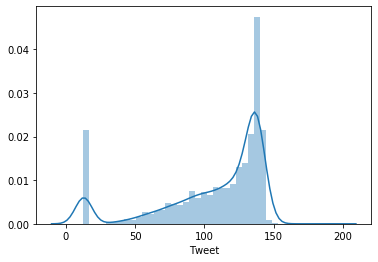

In [32]:
sns.distplot(all_tweets.str.len())

In [33]:
all_tweets.str.len().describe()

count    9970.000000
mean      107.130291
std        38.272575
min         8.000000
25%        90.000000
50%       123.000000
75%       136.000000
max       191.000000
Name: Tweet, dtype: float64

Odfiltrowanie pustych Tweetów, błędnej kategorii Tweet oraz usunięcie wartości pustych

In [34]:
def select_valid_tweets(df, train=True):
    df = df[df['Tweet']!='Not Available']
    if train:
        df = df[df['Category']!='Tweet']
    df = df.dropna()
    return df

Processor kontrakcji trenowany na zbiorze glove z Twittera

In [35]:
contraction_processor = Contractions(api_key="glove-twitter-100")

Pipeline preprocessingu dla danych:
    - Konwersja dataframe na listę Tweetów
    - Parsowanie pod zbiór glove
    - Rozszerzenie kontrakcji (np. we're -> we are)
    - Tokenizacja

In [36]:
def preprocess_dataset(df):
    df_list = [item['Tweet']for _, item in df.iterrows()]
    df_parsed = [twitter_tokenizer(tweet) for tweet in df_list]
    df_expanded = list(contraction_processor.expand_texts(df_parsed,precise=True))
    df_tokens = [tweet_tokenizer.tokenize(tweet) for tweet in df_expanded]
    return df_tokens

In [37]:
train_set = select_valid_tweets(train_data,True)

In [38]:
train_set.shape

(5421, 3)

Wizualizacje poszczególnych kroków przetwarzania

In [39]:
train_list = [item['Tweet']for _, item in train_set.iterrows()]

In [40]:
train_list[:5]

['IOS 9 App Transport Security. Mm need to check if my 3rd party network pod supports it http://t.co/fmtcfUAdgj',
 'Mar if you have an iOS device, you should download our app too: http://t.co/gl3tn2uDnD',
 '@jimmie_vanagon my phone does not run on latest IOS which may account for problem the other day .. time it was replaced',
 "Not sure how to start your publication on iOS? We'll be live helping with ask me anything sessions today and Friday http://t.co/KPqqGjjh3x",
 'Two Dollar Tuesday is here with Forklift 2, QuickKey for iOS and Suite for Pages for just $1.99 today:   http://t.co/BNMFOEACw5']

In [41]:
train_parsed = [twitter_tokenizer(tweet) for tweet in train_list]

In [42]:
train_parsed[:5]

['ios <number> app transport security . mm need to check if my <number> rd party network pod supports it <url> ',
 'mar if you have an ios device , you should download our app too : <url> ',
 ' <user> my phone does not run on latest ios  <allcaps> which may account for problem the other day . <repeat> time it was replaced',
 "not sure how to start your publication on ios ? we'll be live helping with ask me anything sessions today and friday <url> ",
 'two dollar tuesday is here with forklift <number> quickkey for ios and suite for pages for just $ <number> today :  <url> ']

In [43]:
train_expanded = list(contraction_processor.expand_texts(train_parsed,precise=True))

In [44]:
train_expanded[:5]

['ios <number> app transport security . mm need to check if my <number> rd party network pod supports it <url> ',
 'mar if you have an ios device , you should download our app too : <url> ',
 ' <user> my phone does not run on latest ios  <allcaps> which may account for problem the other day . <repeat> time it was replaced',
 'not sure how to start your publication on ios ? we will be live helping with ask me anything sessions today and friday <url> ',
 'two dollar tuesday is here with forklift <number> quickkey for ios and suite for pages for just $ <number> today :  <url> ']

In [45]:
train_tokens = [tweet_tokenizer.tokenize(tweet) for tweet in train_expanded]

In [46]:
train_tokens = preprocess_dataset(train_set)

In [47]:
train_tokens[:2]

[['ios',
  '<number>',
  'app',
  'transport',
  'security',
  '.',
  'mm',
  'need',
  'to',
  'check',
  'if',
  'my',
  '<number>',
  'rd',
  'party',
  'network',
  'pod',
  'supports',
  'it',
  '<url>'],
 ['mar',
  'if',
  'you',
  'have',
  'an',
  'ios',
  'device',
  ',',
  'you',
  'should',
  'download',
  'our',
  'app',
  'too',
  ':',
  '<url>']]

Długości tweetów dla obu zbiorów treningowego oraz testowego w tokenach

In [48]:
lengths = [len(tokens) for tokens in train_tokens]

In [49]:
min(lengths), max(lengths)

(6, 45)

In [50]:
test_set = select_valid_tweets(test_data, False)

In [51]:
test_set.shape

(3640, 2)

In [52]:
test_set.head()

,Id,Tweet
0,628949369883000832,"dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon."
1,628976607420645377,@Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!
4,629186282179153920,If I make a game as a #windows10 Universal App. Will #xboxone owners be able to download and play it in November? @majornelson @Microsoft
5,629226490152914944,"Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft"
6,629345637155360768,@MikeWolf1980 @Microsoft I will be downgrading and let #Windows10 be out for almost the 1st yr b4 trying it again. #Windows10fail


In [53]:
test_tokens = preprocess_dataset(test_set)

In [54]:
lengths_test = [len(tokens) for tokens in test_tokens]

In [55]:
min(lengths_test), max(lengths_test)

(5, 43)

Funkcja służąca do konwersji list tokenów na odpowiadające im zagnieżdżenia ze zbioru Glove. Sekwencja jest padowana zerami do ustalonej według zbioru długości (50), słowa nie mające zagnieżdżeń w zbiorze uzupełniane są zerami

In [56]:
embedding_length = 200
token_number = 50

def get_padding(tweet_length,embedding_length=embedding_length, token_number= token_number):
    padding = [np.zeros((embedding_length,), dtype=np.float32)]*(token_number - tweet_length)
    return padding
def get_embeddings(tokens, glove_dict, length = embedding_length):
    result = []
    for token in tokens:
        embedding = glove_dict.get(token,None)
        if embedding is not None:
            result.append(embedding)
        else:
            result.append(np.zeros((length,), dtype= np.float32))
    result.extend(get_padding(len(tokens)))
    return np.stack(result, axis=0)

In [57]:
get_embeddings(train_tokens[0], glove_dict).shape

(50, 200)

Wybrany model to prosty jednowarstowy LSTM, zakończony warstwą w pełni połączoną z trzema wyjściami softmax. Na wejście podawane są przygotowane wcześniej sekwencje zagnieżdżeń o kształcie (50, 200)

In [58]:
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import LSTM, Dense

c:\users\a\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\a\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\a\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\a\appdata\local\progra

In [59]:
model = Sequential()
model.add(LSTM(200, dropout=0.25, recurrent_dropout=0.1))
model.add(Dense(3,activation='softmax'))

In [60]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [61]:
def encode_sentiment(sentiments, number_of_classes=3):
    number_of_rows = len(sentiments)
    encoding = np.zeros((number_of_rows, number_of_classes))
    for idx, sentiment in enumerate(sentiments):
        encoding[idx,sentiment] = 1
    return encoding

In [62]:
encode_sentiment([0,2,1,1])

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X= np.stack([get_embeddings(tweet_tokens, glove_dict) for tweet_tokens in train_tokens])
y= encode_sentiment(train_set['Category'].replace(cat_mapping),3)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [66]:
X.shape

(5421, 50, 200)

In [67]:
y.shape

(5421, 3)

In [68]:
model.fit(X_train, y_train, epochs=12, batch_size=32,
                    validation_data=(X_test, y_test)) 

Train on 4336 samples, validate on 1085 samples
Epoch 1/12
4336/4336 [==============================] - 11s 3ms/step - loss: 0.9590 - acc: 0.5171 - val_loss: 0.9195 - val_acc: 0.5558
Epoch 2/12
4336/4336 [==============================] - 9s 2ms/step - loss: 0.8659 - acc: 0.5844 - val_loss: 0.8539 - val_acc: 0.5889
Epoch 3/12
4336/4336 [==============================] - 9s 2ms/step - loss: 0.8232 - acc: 0.5916 - val_loss: 0.8578 - val_acc: 0.5687
Epoch 4/12
4336/4336 [==============================] - 9s 2ms/step - loss: 0.8003 - acc: 0.6082 - val_loss: 0.8749 - val_acc: 0.5954
Epoch 5/12
4336/4336 [==============================] - 9s 2ms/step - loss: 0.7795 - acc: 0.6229 - val_loss: 0.8544 - val_acc: 0.5751
Epoch 6/12
4336/4336 [==============================] - 9s 2ms/step - loss: 0.7720 - acc: 0.6185 - val_loss: 0.8405 - val_acc: 0.5871
Epoch 7/12
4336/4336 [==============================] - 9s 2ms/step - loss: 0.7420 - acc: 0.6467 - val_loss: 0.8267 - val_acc: 0.5982
Epoch 8/12
43

In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  320800    
_________________________________________________________________
dense (Dense)                multiple                  603       
Total params: 321,403
Trainable params: 321,403
Non-trainable params: 0
_________________________________________________________________


Przykładowe wyniki na zbiorze testowym

In [70]:
test_embeddings = np.stack([get_embeddings(test_token,glove_dict) for test_token in test_tokens])

In [71]:
list(zip(test_set['Tweet'],model.predict(test_embeddings)))[:5]

[("dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.",
  array([0.06003472, 0.83567595, 0.10428938], dtype=float32)),
 ("@Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!",
  array([0.8435146 , 0.1477607 , 0.00872462], dtype=float32)),
 ('If I make a game as a #windows10 Universal App. Will #xboxone owners be able to download and play it in November? @majornelson @Microsoft',
  array([0.01711331, 0.57565737, 0.40722933], dtype=float32)),
 ('Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft',
  array([0.2511263 , 0.6548148 , 0.09405895], dtype=float32)),
 ('@MikeWolf1980 @Microsoft I will be downgrading and let #Windows10 be out for almost the 1st yr b4 trying it again. #Windows10fail',
  array([0.1221139 , 0.74761194, 0.13027416], dtype=float32))]

Pipeline dla danych testowych, przetwarzanie i podstawowa predykcja odbywają się identycznie. Predykcje sprowadzane są do ostatecznych klas przy pomocy funkcji argmax. Dla brakujących tweetów dokonywana jest naiwna predykcja w postaci klasy większościowej (positive).

In [72]:
def predict_for_NA_NaN(X_test, pred_class = 'positive'):
    result=[]
    for _,row in X_test.iterrows():
        if row['Tweet'] == 'Not Available':
            result.append((row['Id'],pred_class))
    return pd.DataFrame(result, columns=['Id','Category'])

def test_pipeline(test_raw, model):
    missing_df = predict_for_NA_NaN(test_raw)
    test_set = select_valid_tweets(test_raw, train=False)
    test_tokens = preprocess_dataset(test_set)
    
    X_test = np.stack([get_embeddings(tweet_tokens, glove_dict) for tweet_tokens in test_tokens])
    preds = model.predict(X_test)
    preds_argmax = pd.Series(np.argmax(preds,axis=1))
    test_df = pd.DataFrame(zip(test_set['Id'],preds_argmax.replace(reverse_cat_mapping)), columns=['Id','Category'])
    submission = pd.concat([missing_df,test_df])
    return submission

In [73]:
sub = test_pipeline(test_data,model)

In [74]:
sub['Id'] = sub['Id'].astype(np.int64)

In [75]:
sub.to_csv('emotional_tweets_submission8.csv', index=False)